In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, ShapleyKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True
ylim = [0., 0.8]

## The model

In [2]:
model = Ishigami()
dim = model.dim
model.copula = ot.NormalCopula(dim)
theta = 0.

## Sobol indices with a classical Monte-Carlo sampling

In [3]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_perms = None
No = 50
Ni = 100
Nv = 1000

max_budget = Nv + No * Ni * np.math.factorial(dim) * (dim - 1)
n_sample = int(max_budget / (dim*4))
print('Max budget:', max_budget)

# Evaluate the model
shapley = ShapleyIndices(model.input_distribution)
shapley.build_mc_sample(model=model, n_perms=n_perms, Nv=Nv, No=No, Ni=Ni)

Max budget: 61000


In [4]:
n_boot = 1000
shapley_results = shapley.compute_indices(n_boot=n_boot)

In [5]:
shapley_results.true_first_indices = model.first_order_sobol_indices
shapley_results.true_total_indices = model.total_sobol_indices
shapley_results.true_shapley_indices = model.shapley_indices

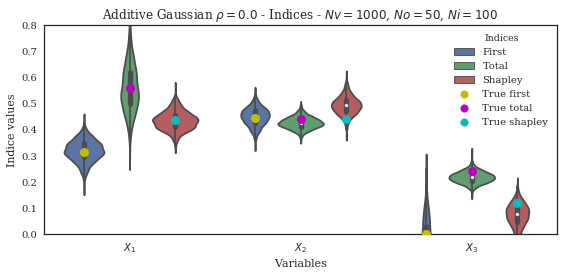

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapley_additive_gaussian.pdf')

In [7]:
def get_confidence_interval(results, quantiles=[2.5, 97.5]):
    """
    """
    interval = 2*results[:, 0].T - np.percentile(results, quantiles[::-1], axis=1)
    return interval.T

In [8]:
get_confidence_interval(shapley_results.full_shapley_indices)

array([[ 0.35941595,  0.50358483],
       [ 0.42017485,  0.56003384],
       [-0.00308683,  0.1552568 ]])

In [9]:
get_confidence_interval(shapley_results.full_first_indices)

array([[ 0.23557871,  0.39189097],
       [ 0.38061321,  0.51047373],
       [-0.25262732,  0.16919825]])

In [10]:
get_confidence_interval(shapley_results.full_total_indices)

array([[ 0.37112397,  0.73266884],
       [ 0.38616487,  0.47290184],
       [ 0.17805032,  0.26113897]])

## Kriging Model

In [14]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 300
basis = 'quadratic'
kernel = 'matern'
library = 'sklearn'
sampling = 'lhs'
shapley_kriging = ShapleyKrigingIndices(model.input_distribution)
meta_model = shapley_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library,
                                             sampling=sampling)

In [15]:
n_sample_cv = 10000
score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='monte-carlo')
print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

Cross Validation Q2 score with 10000 observations: 0.931296347372


In [16]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_realization = 500
No = 100
Ni = 100
Nv = 5000
max_budget = Nv + No * Ni * np.math.factorial(dim) * (dim - 1)
n_sample = int(max_budget / (dim*4))
print('Max budget:', max_budget)

# Evaluate the kriging model
shapley_kriging.build_mc_sample(model=meta_model, n_perms=None, Nv=Nv, No=No, Ni=Ni, n_realization=n_realization)

Max budget: 125000
Sample size is too large. A loop is done to save memory.
Wall time: 1min 32s


In [17]:
%%time
n_boot = 1000
shapley_kriging_results = shapley_kriging.compute_indices(n_boot=n_boot)

Wall time: 30min 51s


In [18]:
shapley_kriging_results.true_first_indices = model.first_order_sobol_indices
shapley_kriging_results.true_total_indices = model.total_sobol_indices
shapley_kriging_results.true_shapley_indices = model.shapley_indices

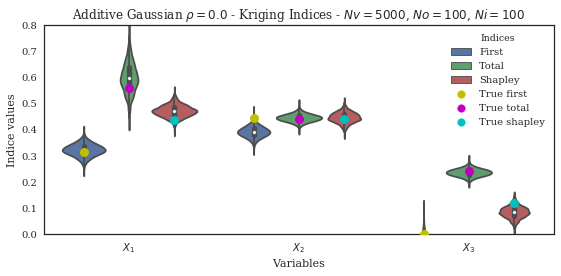

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_kriging_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapleyGP_additive_gaussian.pdf')

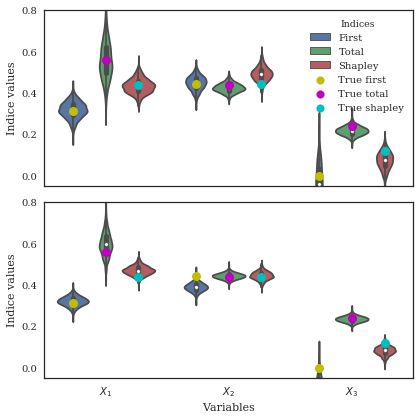

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_xlabel('')
ax.set_ylim([-0.05, 0.8])

ax = axes[1]
plot_sensitivity_results(shapley_kriging_results, indice='all', ax=ax)
ax.set_ylim([-0.05, 0.8])
ax.legend([])
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapley_GP_both_Kriging_ishigami.pdf')

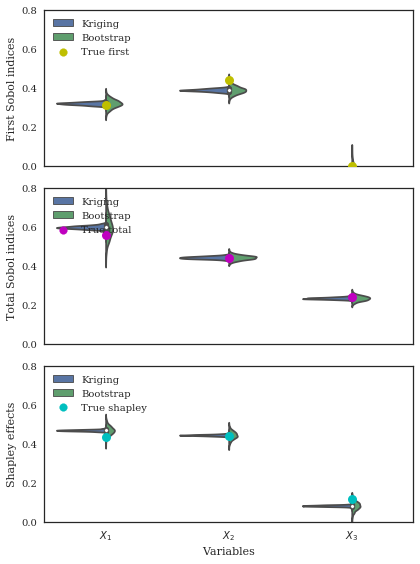

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_kriging_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(shapley_kriging_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(shapley_kriging_results, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapleyGP_boot_gp_errors_additive_ishigami.pdf')